In [40]:
import os
import h5py
import pandas as pd
import numpy as np
import scipy as sp
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
import cufflinks as cf
tls.set_credentials_file(username=os.environ.get('PLOTLY_USERNAME'),
                         api_key=os.environ.get('PLOTLY_APIKEY'))
cf.set_config_file(offline=False, world_readable=True, theme='pearl')

import seaborn as sns

In [10]:
%matplotlib notebook

In [2]:
# load data
hdf_file = 'datasets/store_614_20171107.h5'
hdf = h5py.File(hdf_file, 'r')
for key in hdf.keys():
    print(key)

gallons_per_hour
mean_gallons_per_how
num_transactions_per_how
total_gallons_per_how
transactions
transactions_per_hour


In [19]:
# read a slice of data
df = pd.read_hdf(hdf_file, 'gallons_per_hour')

In [20]:
# ensure the time series is complete in resolution
time_std = df.reset_index().diff().date_hour[1:].std().total_seconds()
while time_std != 0.:
    print('Time series not complete, stddev of {:.2f} seconds, not zero; Fixing...'.format(time_std))
    df = df.asfreq(freq='1h').ffill()
    time_std = df.reset_index().diff().date_hour[1:].std().total_seconds()
print('Fixed')

Time series not complete, stddev of 287.65 seconds, not zero; Fixing...
Fixed


In [21]:
# add a log transform
df['log_gallons_per_hour'] = df.apply(lambda x: np.log(x))

<IPython.core.display.Javascript object>


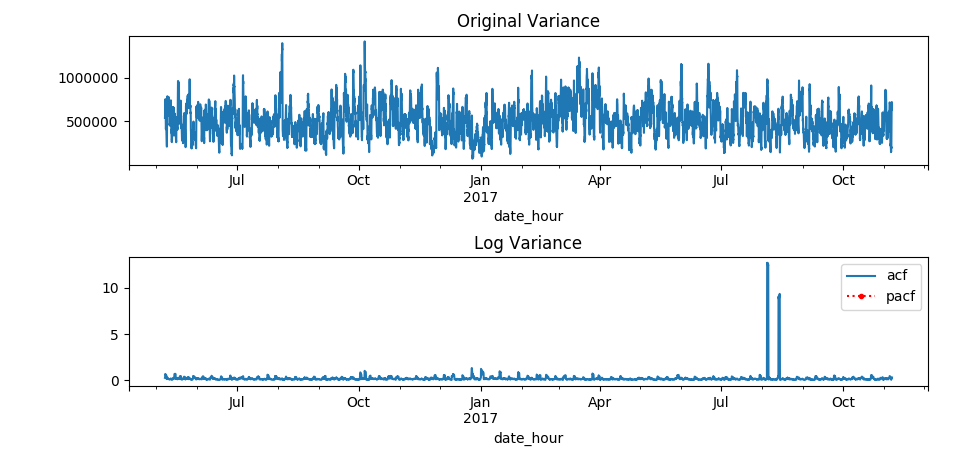

In [22]:
# check variances
df['var'] = df.gallons_per_hour.rolling(window=24).var()
df['log_var'] = df.log_gallons_per_hour.rolling(window=24).var()

# plot variances
fig, ax = plt.subplots(2, 1)
df['var'].plot(ax=ax[0], title='Original Variance')  
df['log_var'].plot(ax=ax[1], title='Log Variance')
fig.tight_layout()  

In [24]:
# time step differencing
df['log_diff'] = df.log_gallons_per_hour - df.log_gallons_per_hour.shift()

In [25]:
# add some lags
lags = np.arange(4, 28, 4)
for lag in lags:
    df['lag_'+str(lag)] = df.log_gallons_per_hour.shift(lag)

In [26]:
# dump the seemingly unneeded values
df.drop(['gallons_per_hour', 'var', 'log_var'], axis=1, inplace=True)

<IPython.core.display.Javascript object>


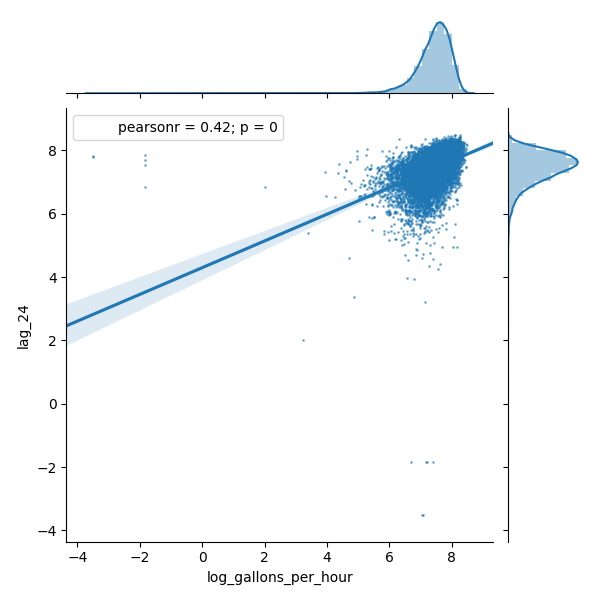

In [27]:
# see distro of lags
sns.jointplot(x='log_gallons_per_hour', y='lag_24', data=df,
              kind='reg',
              scatter_kws={"s": 1, "alpha": 0.5})

In [53]:
# programatically test lag correlations
from statsmodels.tsa.stattools import acf  # auto-correlation function
from statsmodels.tsa.stattools import pacf  # partial auto-correlation function

# acf computes corr of variable and itself at each lag
acf_lag = acf(df.log_diff.dropna(), nlags=24*7, fft=True)  

# pacf computes corr at each lag NOT already explained by prev lags
pacf_lag = pacf(df.log_diff.dropna(), nlags=24*7)

<IPython.core.display.Javascript object>


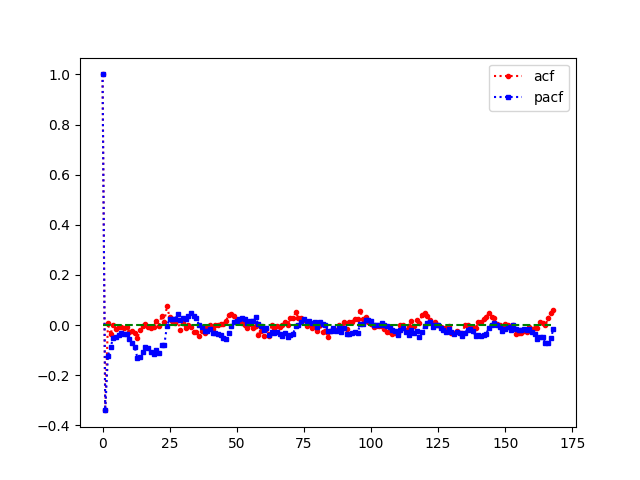

In [54]:
# plot
x = np.arange(0, 24*7)
fig, ax = plt.subplots()  
plt.plot(acf_lag, marker='o', linestyle=':', color='r', ms=3)
plt.plot(pacf_lag, marker='s', linestyle=':', color='b', ms=3)
plt.plot(x, 0*x, color='g', linestyle='--')
plt.legend(['acf', 'pacf'])

In [41]:
# try seasonal decomposition
x = df[['log_gallons_per_hour']]
decomp = sm.tsa.seasonal_decompose(x, freq=24, model='additive')
decomp = decomp.observed.join(decomp.trend,
                              rsuffix='_trend').join(decomp.seasonal,
                                                     rsuffix='_seasonal').join(decomp.resid,
                                                                               rsuffix='_resid')

In [57]:
# plot interactively
decomp.iplot()

The draw time for this plot will be slow for clients without much RAM.


/usr/local/lib/python3.6/site-packages/plotly/api/v1/clientresp.py:40: UserWarning:

Estimated Draw Time Slow

